In [1]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import os

In [2]:
prediction_df = pd.read_csv('../data/interim/ecor_predictions.csv')

/state/partition1/slurm_tmp/26118226.0.0/ipykernel_3062643/2087328685.py:1: DtypeWarning: Columns (21,27) have mixed types. Specify dtype option on import or set low_memory=False.
  prediction_df = pd.read_csv('../data/interim/ecor_predictions.csv')


In [3]:
len(prediction_df)

321347

In [4]:
cloned_regions = pd.read_csv('../data/external/Beaker validation completed clones.csv')

## Get operons that have already been cloned

In [5]:
exploded_cloned = cloned_regions.copy()
exploded_cloned['Proteins'] = exploded_cloned['Proteins'].str.split(',')
exploded_cloned = exploded_cloned.explode('Proteins')
merged_cloned = (exploded_cloned.rename(columns={'Proteins': 'product_accession',
                                                 'Nucleotide Accession': 'genomic_accession'})
                 .merge(prediction_df, how='inner', on=['product_accession', 'genomic_accession']))
valid_working_ids = (merged_cloned.groupby('Working ID')
                       .agg(n_operons=('operon', 'nunique'))
                       .query('n_operons == 1')
                       .index.to_list())
cloned_operon_sizes = (merged_cloned[merged_cloned['Working ID'].isin(valid_working_ids)]
                       .groupby(['operon'])
                       .agg(cloned_n_proteins=('product_accession', 'count'))
                       .reset_index())
defined_operon_sizes = (prediction_df.groupby('operon')
                        .agg(operon_size=('product_accession', 'count'))
                        .reset_index())
merged_operon_sizes = (cloned_operon_sizes.merge(defined_operon_sizes, on='operon'))
correct_cloned_operons = merged_operon_sizes.loc[(merged_operon_sizes['operon_size'] == merged_operon_sizes['cloned_n_proteins']), 
                                                 'operon']
print(str(len(correct_cloned_operons)/len(cloned_regions) * 100), 'percent (n =' , str(len(correct_cloned_operons)) + ') of cloned operons are valid')


94.36619718309859 percent (n = 67) of cloned operons are valid


## Get candidate defense proteins and pick one protein per cluster

We'll select a list of operons as follows:

1. Filter out operons that are at a contig edge
2. Select proteins that have a probability of defense greater than 0.5, are not defense homolog, are not MG1655 homologs
3. Select operons that have already been cloned
4. Iteratively select the most highly predicted operon until there are no more proteins to select

In [6]:
blacklisted_operons = prediction_df.loc[prediction_df['contig_end'], 
                                        'operon']

In [7]:
prediction_df['predicted_defense'] = (prediction_df['beaker_prediction'] > 0.5)

In [12]:
prediction_df['predicted_defense'].sum()

4603

In [8]:
prediction_df['blacklisted_operon'] = prediction_df['operon'].isin(blacklisted_operons)

In [15]:
(prediction_df['predicted_defense'] &
 ~prediction_df['defense_homolog'] & 
 ~prediction_df['MG1655_homolog'] & 
 ~prediction_df['blacklisted_operon']).sum()

1545

In [19]:
candidate_proteins = (prediction_df[(prediction_df['beaker_prediction'] > 0.5) &
                                    ~prediction_df['operon'].isin(blacklisted_operons) &
                                    ~prediction_df['defense_homolog'] &
                                    ~prediction_df['MG1655_homolog']]
                      .sort_values('beaker_prediction', ascending=False))

In [20]:
candidate_proteins['cluster_id'].nunique()

591

In [22]:
candidate_proteins.to_csv('../data/interim/easy_filt_novel_def_proteins.csv', index=False)

In [17]:
select_protein_operons = prediction_df[prediction_df['operon'].isin(correct_cloned_operons)].reset_index(drop=True)
select_protein_operons['cloned'] = True

In [18]:
candidate_proteins = candidate_proteins[~candidate_proteins['cluster_id'].isin(select_protein_operons['cluster_id'])]

In [36]:
select_protein_list = []
while len(candidate_proteins):
    curr_operon = candidate_proteins.head(1).squeeze()['operon']
    curr_operon_df = prediction_df[prediction_df['operon'] == curr_operon]
    select_protein_list.append(curr_operon_df)
    candidate_proteins = candidate_proteins[~candidate_proteins['cluster_id'].isin(curr_operon_df['cluster_id'])]

In [41]:
select_protein_operons = pd.concat([select_protein_operons] + select_protein_list)
select_protein_operons['cloned'] = select_protein_operons['cloned'].fillna(False)

In [43]:
select_protein_operons['operon'].nunique()

538

In [45]:
select_protein_operons['cluster_id'].nunique()

851

In [47]:
len(select_protein_operons)

881

In [48]:
select_protein_operons['name'].value_counts().head(20)

name
hypothetical protein                                     488
type II toxin-antitoxin system RelE/ParE family toxin     18
ATP-binding protein                                       12
AAA family ATPase                                         10
site-specific integrase                                    8
restriction endonuclease                                   6
helix-turn-helix domain-containing protein                 6
TIR domain-containing protein                              5
DUF2971 domain-containing protein                          5
tyrosine-type recombinase/integrase                        5
restriction endonuclease subunit S                         5
response regulator receiver domain                         4
type II toxin-antitoxin system ParD family antitoxin       4
WGR and DUF4132 domain-containing protein                  4
phage repressor protein CI                                 4
HNH endonuclease                                           4
type IA DNA topoiso

<Axes: xlabel='beaker_prediction', ylabel='Count'>

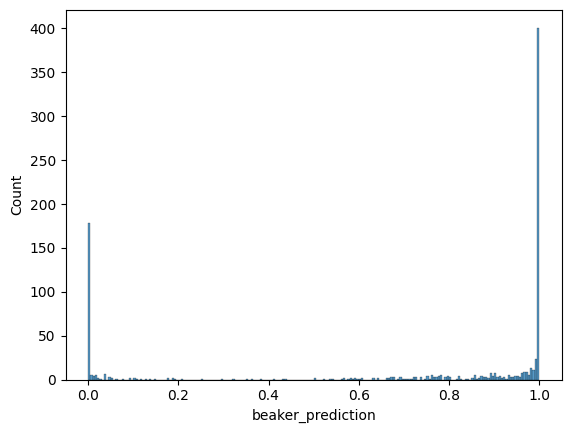

In [51]:
sns.histplot(select_protein_operons['beaker_prediction'], binwidth=0.005)

In [52]:
prefilt_new_defense_prots = (select_protein_operons
                             [select_protein_operons['beaker_prediction'] > 0.5]
                             .sort_values('beaker_prediction', ascending=False)
                             .groupby('cluster_id')
                             .head(1))
len(prefilt_new_defense_prots)

638

In [54]:
out_prefilt_pd_seq_acc = '../data/interim/prefilt_pd_seq_acc.txt'
prefilt_pd_seqs = prefilt_new_defense_prots['product_accession'].drop_duplicates()
prefilt_pd_seqs.to_csv(out_prefilt_pd_seq_acc, index=False)

In [56]:
out_prefilt_pd_seqs = '../data/interim/ecor_pd_seqs_prefilt.faa'

In [57]:
os.system(' '.join(['conda run -n beaker', 
                    'seqtk subseq',
                    '../data/interim/ecor_unique_seqs.faa', 
                    out_prefilt_pd_seq_acc, '>',
                    out_prefilt_pd_seqs]))

0

We'll query the sequences in a new script so we can use a machine with more memory

In [59]:
select_protein_operons.to_csv('../data/interim/prefilt_pd_prediction_df.csv', index=False)